### About This Classifier

This binary-class sentiment classifier is powered by the Google BERT based uncased model, with 12 layers and a hidden layer size of 768 for a total of 110M parameters. On top of the BERT layer are four fully connected layers, the first three of which use a ReLU activation function, that condense down to two neurons, which output the binary class logits. We then softmax and argmax the logits to generate our final class prediction. When training our model, we chose the Cross Entropy loss function and the SGD optimizer with a learning rate of 1e-3 and a momentum of 0.9. We trained our model for 16 epochs, processing the data in batches of 64 and saving only the best model.

### Import Statements

In [1]:
from datetime import datetime

import seaborn as sns
import torch
from matplotlib import pyplot as plt
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torch.utils.tensorboard import SummaryWriter

from src.dataset import ReviewDataset
from src.dataloader_tokenized import ReviewDataLoader
from src.tokenizer import Tokenizer
from src.classifier_binary import Classifier, Trainer, Tester

### Environment Variables

In [2]:
data_path_train = "../../data/train.csv"
data_path_test = "../../data/test.csv"
model = "google-bert/bert-base-uncased"
max_length = 256
batch_size = 64
out_path = '../../models/binary_classifier_model_best.pt'

### Load Data

In [3]:
dataset_training = ReviewDataset(data_path_train)
dataset_testing = ReviewDataset(data_path_test)
tokenizer = Tokenizer(model, max_length)
dataloader_training = ReviewDataLoader(dataset_training, tokenizer, batch_size)
dataloader_testing = ReviewDataLoader(dataset_testing, tokenizer, batch_size)

### Initialize Model

In [4]:
classifier = Classifier(model)
classifier

Classifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine

### Setup Training

In [5]:
learning_rate = 0.001
momentum = 0.9
num_epochs = 16
criterion = CrossEntropyLoss()
optimizer = SGD(classifier.parameters(), lr=learning_rate, momentum=momentum)
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter(f'../../runs/trainer_{timestamp}')
trainer = Trainer(classifier, criterion, optimizer, dataloader_training, dataloader_testing, writer, out_path)
tester = Tester(classifier, criterion, dataloader_testing)

### Training

In [6]:
train_losses, train_acc, val_losses, val_acc = trainer.train(num_epochs)

Epoch 1/16
Train Loss: 0.596623 | Train Accuracy: 0.702250
Val Loss: 0.539589 | Val Accuracy: 0.699815
Val loss decreased from inf to 0.539589. Saving model...
Epoch 2/16
Train Loss: 0.403863 | Train Accuracy: 0.809181
Val Loss: 0.320247 | Val Accuracy: 0.863130
Val loss decreased from 0.539589 to 0.320247. Saving model...
Epoch 3/16
Train Loss: 0.329947 | Train Accuracy: 0.858569
Val Loss: 0.313990 | Val Accuracy: 0.865309
Val loss decreased from 0.320247 to 0.313990. Saving model...
Epoch 4/16
Train Loss: 0.321910 | Train Accuracy: 0.862494
Val Loss: 0.291483 | Val Accuracy: 0.878182
Val loss decreased from 0.313990 to 0.291483. Saving model...
Epoch 5/16
Train Loss: 0.319041 | Train Accuracy: 0.864161
Val Loss: 0.284236 | Val Accuracy: 0.882912
Val loss decreased from 0.291483 to 0.284236. Saving model...
Epoch 6/16
Train Loss: 0.313822 | Train Accuracy: 0.867687
Val Loss: 0.281681 | Val Accuracy: 0.883693
Val loss decreased from 0.284236 to 0.281681. Saving model...
Epoch 7/16
Trai

### Plot Training

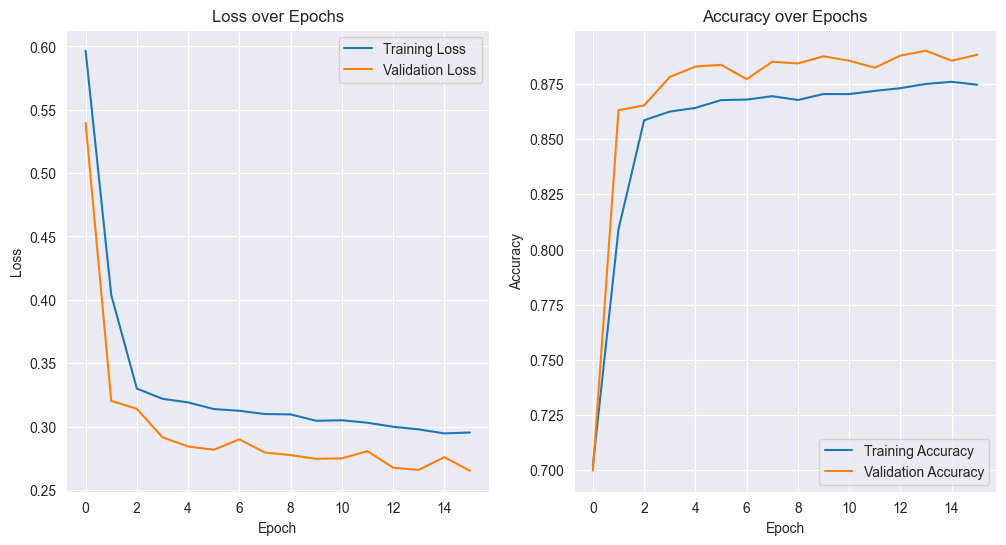

In [7]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.show()

### Load Best Model

In [8]:
classifier.load_state_dict(torch.load(out_path))

<All keys matched successfully>

### Testing

In [9]:
test_loss, test_acc, test_f1, test_auroc, test_cm = tester.test()

### Results

In [10]:
print(f'Test Loss: {test_loss: .6f} | Test Accuracy: {test_acc: .6f} | Test F1: {test_f1: .6f} | Test AUROC: {test_auroc: .6f}')

Test Loss:  0.265131 | Test Accuracy:  0.888258 | Test F1:  0.922555 | Test AUROC:  0.846464


### Confusion Matrix

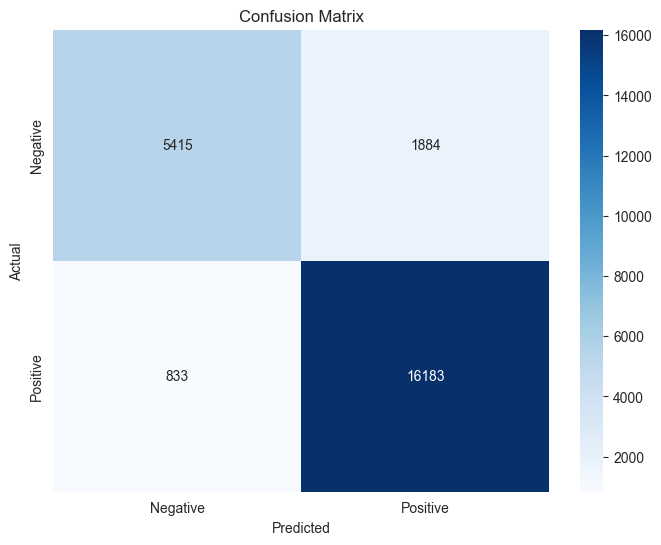

In [11]:
plt.figure(figsize=(8, 6))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()